# 导入库

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']

plt.rcParams['axes.unicode_minus'] = False

In [48]:
def cal_MAE_MSE(a,b):
    if len(a)!=len(b):
        return "error"
    
    sum1 = 0
    sum2 = 0
    for i in range(len(a)):
        sum1 += (a[i]-b[i])**2
    
        sum2 += abs(a[i]-b[i])
    
    sum1 = sum1/len(a)
    sum1_2 = sum1**(1/2)
    sum2 = sum2/len(a)
    return [sum1,sum1_2,sum2]

# 上证

In [2]:
import tushare as ts

share_prices = ts.get_k_data('000001', start='2018-01-01',end = '2021-06-04',index=True)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [3]:
share_prices = share_prices.set_index("date")

In [4]:
share_prices["high"]

date
2018-01-02    3349.05
2018-01-03    3379.92
2018-01-04    3392.83
2018-01-05    3402.07
2018-01-08    3412.73
               ...   
2021-05-31    3615.66
2021-06-01    3626.07
2021-06-02    3629.29
2021-06-03    3618.51
2021-06-04    3618.80
Name: high, Length: 831, dtype: float64

## 数据预处理

In [5]:
data = share_prices["high"].values
sub = 583
train = data[:sub]
test = data[sub:]

Text(0.5, 1.0, '上证指数：原始时间序列')

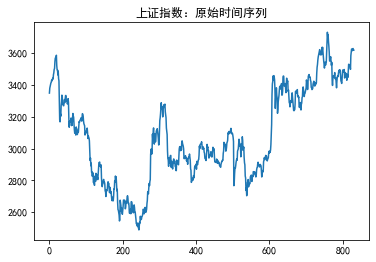

In [6]:
plt.plot(data)
plt.title("上证指数：原始时间序列")

对数变换与量纲

In [7]:
from sklearn.preprocessing import MinMaxScaler

Text(0.5, 1.0, '上证指数：预处理后的时间序列')

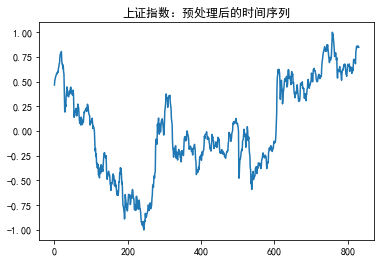

In [8]:
#数据预处理
ts_log = np.log(data)
#plt.plot(ts_log)
#plt.title(stock_name + "：对数变换序列")
    
ts_log = ts_log.astype('float32')  # 转换数据类型: obj ->float
scaler = MinMaxScaler(feature_range=(-1, 1))
pre_data = scaler.fit_transform(ts_log.reshape(-1, 1))

plt.plot(pre_data)
plt.title("上证指数：预处理后的时间序列")

## 一、自回归整合移动平均模型(ARIMA)¶

由前面的图可知，该序列是不平稳的，然而平稳性是时间序列分析的前提条件，故我们需要对不平稳的序列进行处理将其转换成平稳的序列。

In [9]:
#adf检验
adftest = adfuller(pre_data)
print(adftest)

(-1.5254857875982595, 0.5208683350088356, 1, 829, {'1%': -3.438262743153934, '5%': -2.8650327208928976, '10%': -2.5686298171529347}, -2497.452025162172)


In [10]:
ls = pre_data.tolist()
ls = [x[0] for x in ls]

pre_data = pd.Series(ls)

In [11]:
pre_data = pd.Series(pre_data)

1      0.045288
2      0.018814
3      0.013428
4      0.015442
5      0.006504
         ...   
826   -0.008892
827    0.014191
828    0.004383
829   -0.014683
830    0.000397
Length: 830, dtype: float64


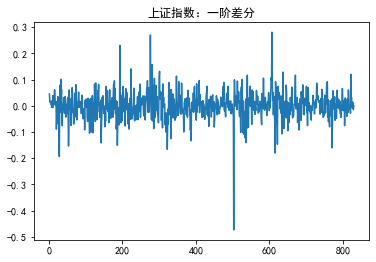

In [12]:
#使用一阶差分
diff1 = pre_data.diff(1).iloc[1:]
plt.plot(diff1)
plt.title("上证指数：一阶差分")
print(diff1)

In [13]:
pre_data

0      0.466007
1      0.511295
2      0.530109
3      0.543537
4      0.558979
         ...   
826    0.844090
827    0.858280
828    0.862663
829    0.847980
830    0.848377
Length: 831, dtype: float64

In [14]:
#adf检验
adftest = adfuller(diff1)
print(adftest)

(-25.356969680130387, 0.0, 0, 829, {'1%': -3.438262743153934, '5%': -2.8650327208928976, '10%': -2.5686298171529347}, -2492.679601350507)


ADF结果小于1% 5% 10%值，且p值接近零，平稳   
ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设     
P-value是否非常接近0.

In [15]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(diff1, lags=[6,12], boxpierce=True) # 数据的纯随机性检验函数

E:\download\anaconda\download\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([21.28979507, 23.67325937]),
 array([0.00162709, 0.02252453]),
 array([21.18040037, 23.53121355]),
 array([0.00170258, 0.02354008]))

Text(0.5, 1.0, '上证指数：ACF图')

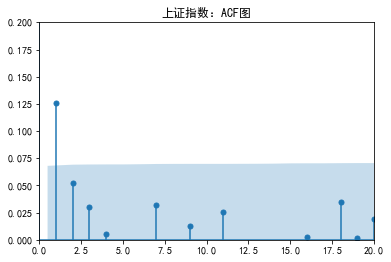

In [16]:
#模型定阶
plot_acf(diff1)
plt.axis([0,20,0,0.2])
plt.title("上证指数：ACF图")

Text(0.5, 1.0, '上证指数：PACF图')

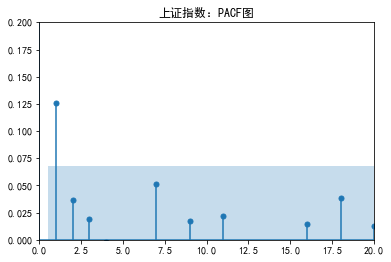

In [17]:
plot_pacf(diff1)
plt.axis([0,20,0,0.2])
plt.title("上证指数：PACF图")

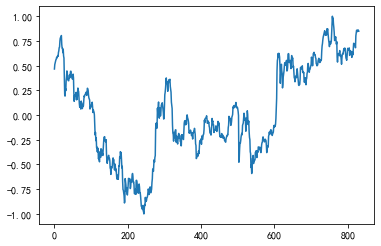

In [18]:
plt.plot(pre_data)

In [19]:
# 加载ARIMA库
res = []
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(pre_data, order=(p,1,q))
            model_fit = model.fit()
            res.append([p,q,model_fit.aic])
        except:
            print("error",p,q)

<ipython-input-19-262b02c89602>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  

error 1 2


E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arim

error 1 4
error 1 5


E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params

error 2 4
error 2 5


E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arim

error 3 4
error 3 5


E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arim

error 4 5


E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arim

In [20]:
min_aic = 0
res_pq = []
for i in res:
    if min_aic>i[2]:
        min_aic = i[2]
        res_pq.append([i[0],i[1]])

In [21]:
res_pq

[[0, 0], [0, 1], [1, 0]]

# ARIMA(0,1,1)

In [22]:
# 训练模型
model = ARIMA(pre_data, order=(0,1,1)) # (ARMA) = (1,1,1)
model_fit = model.fit()

# 预测
forecast = model_fit.predict(start = 528,end = 830,typ='levels')

# 可视化
"""
plt.figure(figsize=(22,10))
plt.plot(pre_data[528:])

plt.figure(figsize=(22,10))
plt.plot(forecast)

plt.figure(figsize=(22,10))
plt.plot(pre_data[528:],label = "original")
plt.plot(forecast)
"""

'\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:])\n\nplt.figure(figsize=(22,10))\nplt.plot(forecast)\n\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:],label = "original")\nplt.plot(forecast)\n'

In [25]:
#差分还原
#new = [pre_data[582]]

#for i in range(len(list(forecast))):
#    temp = new[-1]+forecast.values[i]
#    new.append(temp)
    
#forecast = np.array(forecast)

# 对标准化数据进行还原
#actual_pred = scaler.inverse_transform(forecast.reshape(-1, 1))
#actual_pred = actual_pred.reshape(-1, 1).flatten()

#log还原
#actual_pred = np.exp(actual_pred)


#plt.figure(figsize=(22,10))
#plt.plot(range(len(actual_pred)),actual_pred,label = "predict")
#plt.plot(range(len(data[528:])),data[528:],label = "real")

#plt.legend(loc='best')


In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  830
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1289.263
Method:                       css-mle   S.D. of innovations              0.051
Date:                Mon, 07 Jun 2021   AIC                          -2572.526
Time:                        10:37:50   BIC                          -2558.362
Sample:                             1   HQIC                         -2567.094
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.235      0.814      -0.003       0.004
ma.L1.D.y      0.1163      0.033      3.518      0.000       0.052       0.181
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -8.5979           +0.0000j            8.5979            0.5000
-----------------------------------------------------------------------------
"""

# ARIMA(1,1,1)

In [27]:
# 训练模型
model = ARIMA(pre_data, order=(1,1,1)) # (ARMA) = (1,1,1)
model_fit = model.fit()

# 预测
forecast = model_fit.predict(start = 528,end = 830,typ='levels')

# 可视化
"""
plt.figure(figsize=(22,10))
plt.plot(pre_data[528:])
plt.figure(figsize=(22,10))
plt.plot(forecast)
plt.figure(figsize=(22,10))
plt.plot(pre_data[528:],label = "original")
plt.plot(forecast)
"""

E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arim

'\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:])\nplt.figure(figsize=(22,10))\nplt.plot(forecast)\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:],label = "original")\nplt.plot(forecast)\n'

In [28]:
#差分还原
#new = [pre_data[582]]

#for i in range(len(list(forecast))):
#    temp = new[-1]+forecast.values[i]
#    new.append(temp)
    
#forecast = np.array(forecast)

# 对标准化数据进行还原
#actual_pred = scaler.inverse_transform(forecast.reshape(-1, 1))
#actual_pred = actual_pred.reshape(-1, 1).flatten()

#log还原
#actual_pred = np.exp(actual_pred)


#plt.figure(figsize=(22,10))
#plt.plot(range(len(actual_pred)),actual_pred,label = "predict")
#plt.plot(range(len(data[528:])),data[528:],label = "real")

#plt.legend(loc='best')


In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  830
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1290.408
Method:                       css-mle   S.D. of innovations              0.051
Date:                Mon, 07 Jun 2021   AIC                          -2572.817
Time:                        10:38:00   BIC                          -2553.931
Sample:                             1   HQIC                         -2565.574
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.221      0.825      -0.004       0.005
ar.L1.D.y      0.4011      0.202      1.989      0.047       0.006       0.796
ma.L1.D.y     -0.2797      0.211     -1.327      0.184      -0.693       0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4930           +0.0000j            2.4930            0.0000
MA.1            3.5758           +0.0000j            3.5758            0.0000
-----------------------------------------------------------------------------
"""

# ARIMA(1,1,0)

In [32]:
# 训练模型
model = ARIMA(pre_data, order=(1,1,0)) # (ARMA) = (1,1,1)
model_fit = model.fit()

# 预测
forecast = model_fit.predict(start = 528,end = 830,typ='levels')

# 可视化
"""
plt.figure(figsize=(22,10))
plt.plot(pre_data[528:])
plt.figure(figsize=(22,10))
plt.plot(forecast)
plt.figure(figsize=(22,10))
plt.plot(pre_data[528:],label = "original")
plt.plot(forecast)
"""

E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


'\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:])\nplt.figure(figsize=(22,10))\nplt.plot(forecast)\nplt.figure(figsize=(22,10))\nplt.plot(pre_data[528:],label = "original")\nplt.plot(forecast)\n'

In [33]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  830
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1289.773
Method:                       css-mle   S.D. of innovations              0.051
Date:                Mon, 07 Jun 2021   AIC                          -2573.547
Time:                        10:38:26   BIC                          -2559.382
Sample:                             1   HQIC                         -2568.115
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.231      0.818      -0.004       0.004
ar.L1.D.y      0.1256      0.034      3.648      0.000       0.058       0.193
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.9613           +0.0000j            7.9613            0.0000
-----------------------------------------------------------------------------
"""

# 滚动预测

E:\download\anaconda\download\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'ARIMA模型的滚动预测')

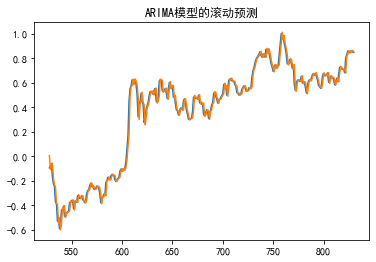

In [39]:
# 训练模型
model = ARIMA(pre_data, order=(1,1,0)) # (ARMA) = (1,1,1)
model_fit = model.fit()

# 预测
forecast = model_fit.predict(start = 528,end = 830,typ='levels')

# 可视化

#plt.figure(figsize=(22,10))
#plt.plot(pre_data[528:])
#plt.figure(figsize=(22,10))
#plt.plot(forecast)
#plt.figure(figsize=(22,10))
plt.plot(pre_data[528:],label = "original")
plt.plot(forecast)
plt.title("ARIMA模型的滚动预测")

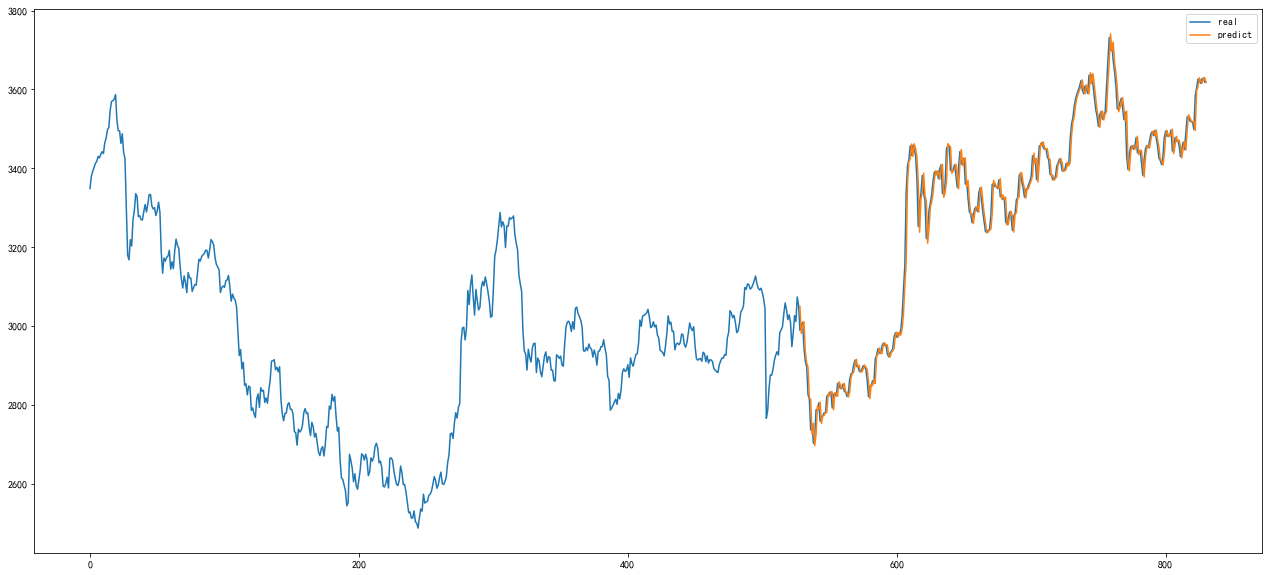

In [44]:
# 对标准化数据进行还原
forecast = np.array(forecast)
actual_pred = scaler.inverse_transform(forecast.reshape(-1, 1))
actual_pred = actual_pred.reshape(-1, 1).flatten()

#log还原
actual_pred = np.exp(actual_pred)


plt.figure(figsize=(22,10))
plt.plot(range(len(data)),data,label = "real")
plt.plot(range(528,528+len(actual_pred)),actual_pred,label = "predict")

plt.legend(loc='best')

In [50]:
cal_MAE_MSE(data[528:],actual_pred)

[977.3335092905212, 31.26233371472004, 22.0700409257068]